<a href="https://colab.research.google.com/github/Khalid-Rafiq-01/Image-Segmentation-Pets-Datset/blob/main/Patch_ResNet34_Small(1500_Patches).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main purpose of this notebook is:
* Train a **basic UNet** and **UNet with pretrained ResNet34 backbone** on the pre-processed data from pre-processing notebook 1 that had been stored in the local colab . **The Preprocessed data is only 40% (roughly 10% effective)of the entire available pets dataset**. The main reson of talking such small dataset being the limitations of RAM handling all the data at once!
* Run predictions on these models and store these models.


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import random
from keras.utils import to_categorical


In [ ]:
train_img_dir = ("/content/drive/MyDrive/Copy of big data/train_images/train")
train_mask_dir = ("/content/drive/MyDrive/Copy of big data/train_masks/train")

In [ ]:
# Let us count the number of numpy arrays (images and masks and sort these numpy arrays):
img_list = os.listdir(train_img_dir)
img_list.sort()
msk_list = os.listdir(train_mask_dir)
msk_list.sort()

num_images = len(img_list)
num_masks = len(msk_list)
print(f'The number of images in the drive is: {num_images}')
print(f'The number of masks in the drive is: {num_masks}')

The number of images in the drive is: 1579
The number of masks in the drive is: 1579


*Observe that this represents only 40% effective only around 10% of the total training data, where each image is of the size (256,256,-)*

*Sanity check for an image and a mask*

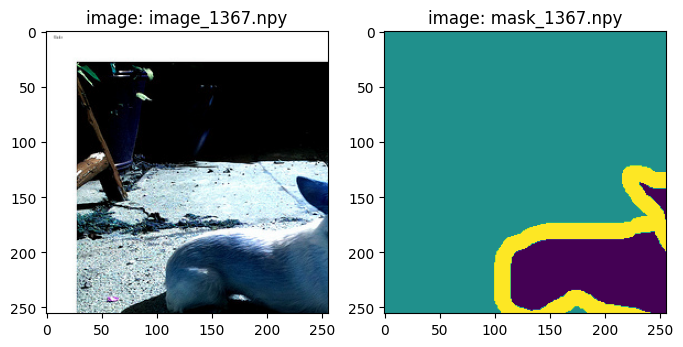

The unique values of pixels in my mask are: [0 1 2]


In [ ]:
# Taking a random number from 0-len(images): f'{val_img_dir}/image_{i}.npy
num = random.randint(0, num_images-1)
img_for_plot = img_list[num]
mask_for_plot = msk_list[num]
rand_image = np.load(f'{train_img_dir}/{img_for_plot}') # Values between 0-1
rand_mask = np.load(f'{train_mask_dir}/{mask_for_plot}')

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(rand_image)
plt.title(f'image: {img_for_plot}')

plt.subplot(122)
plt.imshow(rand_mask)
plt.title(f'image: {mask_for_plot}')
plt.show()

print(f'The unique values of pixels in my mask are: {np.unique(rand_mask)}')

*Let us try to create an input pipeline generator*

In [ ]:
val_img_dir = ('/content/drive/MyDrive/Copy of big data/val_images/val')
val_img_mask = ('/content/drive/MyDrive/Copy of big data/val_masks/val')

**Loading the data from the drive**
*Need to create a Generator to flow in data*

In [ ]:
train_images = []
train_masks = []

for i in range(num_images):
  images = np.load(f'{train_img_dir}/image_{i}.npy')
  masks = np.load(f'{train_mask_dir}/mask_{i}.npy')
  masks_categorical = to_categorical(masks)
  train_images.append(images)
  train_masks.append(masks_categorical)
  print(f'Done - {i}')

Done - 0
Done - 1
Done - 2
Done - 3
Done - 4
Done - 5
Done - 6
Done - 7
Done - 8
Done - 9
Done - 10
Done - 11
Done - 12
Done - 13
Done - 14
Done - 15
Done - 16
Done - 17
Done - 18
Done - 19
Done - 20
Done - 21
Done - 22
Done - 23
Done - 24
Done - 25
Done - 26
Done - 27
Done - 28
Done - 29
Done - 30
Done - 31
Done - 32
Done - 33
Done - 34
Done - 35
Done - 36
Done - 37
Done - 38
Done - 39
Done - 40
Done - 41
Done - 42
Done - 43
Done - 44
Done - 45
Done - 46
Done - 47
Done - 48
Done - 49
Done - 50
Done - 51
Done - 52
Done - 53
Done - 54
Done - 55
Done - 56
Done - 57
Done - 58
Done - 59
Done - 60
Done - 61
Done - 62
Done - 63
Done - 64
Done - 65
Done - 66
Done - 67
Done - 68
Done - 69
Done - 70
Done - 71
Done - 72
Done - 73
Done - 74
Done - 75
Done - 76
Done - 77
Done - 78
Done - 79
Done - 80
Done - 81
Done - 82
Done - 83
Done - 84
Done - 85
Done - 86
Done - 87
Done - 88
Done - 89
Done - 90
Done - 91
Done - 92
Done - 93
Done - 94
Done - 95
Done - 96
Done - 97
Done - 98
Done - 99
Done - 100

In [ ]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)
print(train_images.shape)
print(train_masks.shape)

(1579, 256, 256, 3)
(1579, 256, 256, 3)


In [ ]:
val_img_list = os.listdir(val_img_dir)
val_msk_list = os.listdir(val_img_mask)

num_images = len(val_img_list)

In [ ]:
val_images = []
val_masks = []

for i in range(num_images):
  images = np.load(f'{val_img_dir}/image_{i}.npy')
  masks = np.load(f'{val_img_mask}/mask_{i}.npy')
  masks_categorical = to_categorical(masks) # Converting the masks to categorical loss!
  val_images.append(images)
  val_masks.append(masks_categorical)

*Loading the masks from the directory into the colab space*

In [ ]:
val_images = np.array(val_images)
val_masks = np.array(val_masks)
print(val_images.shape)
print(val_masks.shape)

(84, 256, 256, 3)
(84, 256, 256, 3)


*Plotting a random image and a mask just for cross checking purpose*

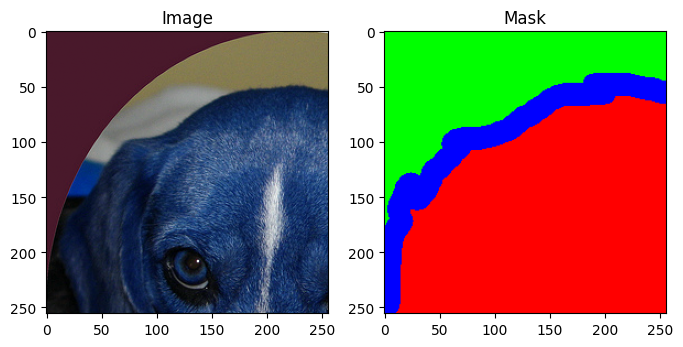

In [ ]:
num = random.randint(0, num_images-1)
img_for_plot = val_images[num]
mask_for_plot = val_masks[num]

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot)
plt.title('Mask')
plt.show()

#Defining the model architecture: A basic UNet Model

In [ ]:
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Conv2DTranspose, Input, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
classes = 3
image_height = 256
image_width = 256
channels = 3

In [ ]:
# Defining basic functions for developing the UNet Model----: (# Adding Normalization to the UNet model)
# Let us first define the convolution block: 2*(3,3) convs. Both conv have same num_filters:

def conv_block(input, num_filters):
  x = Conv2D(filters = num_filters, kernel_size = (3,3), kernel_initializer='he_normal', padding='same')(input)
  x = BatchNormalization()(x) # Adding a batch_normalization layer
  x = Activation('relu')(x)

  x = Conv2D(filters = num_filters, kernel_size = (3,3), kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x) # Adding a batch_normalization layer
  x = Activation('relu')(x)
  return x

# Let us now define the Encoding Block:
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling2D(pool_size=(2, 2))(x)
  return x, p

# Let us now define the Decoding Block: up conv (2,2) --> Concatination --> (3,3) ReLu convs
def decoder_block(inputs, skip_features, num_filters):
  x = Conv2DTranspose(filters=num_filters, kernel_size=(2,2), strides=2, padding='same')(inputs)
  x = keras.layers.concatenate([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [ ]:
# Building the basic U-Net Model:

def basic_unet_model(classes, image_height, image_width, channels):
  # Defining the input:
  inputs = Input((image_height, image_width, channels))
  #Creating and augmentation layer:
  #x = image_augment(inputs)

  # Defining the Encoding section: 
  s1, p1 = encoder_block(inputs, 16) # s will be used for skip outputs for concatination #(256,256)
  s2, p2 = encoder_block(p1, 32)     # (128,128)
  s3, p3 = encoder_block(p2, 64)     # (64,64)
  s4, p4 = encoder_block(p3, 128)    #  (32,32) ---> (16,16,128)


  # Bridge:
  b1 = conv_block(p4,256)   # (8,8,512)


  # Decoder:
  d1 = decoder_block(b1,s4,128)   # observe that size(s1)
  d2 = decoder_block(d1,s3,64)
  d3 = decoder_block(d2,s2,32)
  d4 = decoder_block(d3,s1,16)

  # Output:
  outputs = Conv2D(filters = classes, kernel_size = 1, padding = "same", activation = "softmax")(d4)

  # Compiling the Model:
  model = Model(inputs=inputs, outputs=outputs)
  return model

# Getting the basic Unet Model:

def get_basic_unet_model():
  return basic_unet_model(classes=classes, 
                    image_height=image_height, 
                    image_width=image_width, 
                    channels=channels)
basic_model = get_basic_unet_model()
basic_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from keras.optimizers import Adam
lr = 0.0005

In [ ]:
basic_model.compile(optimizer = Adam(learning_rate=lr), loss="categorical_crossentropy", metrics = ['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint("pets_segmentation_basic_tiles_small.h5", save_best_only=True)
]

In [ ]:
model_history_tiles_small = basic_model.fit(train_images,train_masks, epochs=10, validation_data=(val_images, val_masks), callbacks=callbacks)

Epoch 1/10
50/50 [==============================] - 41s 477ms/step - loss: 1.0097 - accuracy: 0.5186 - val_loss: 1.3203 - val_accuracy: 0.5437
Epoch 2/10
50/50 [==============================] - 17s 332ms/step - loss: 0.7152 - accuracy: 0.7332 - val_loss: 1.3137 - val_accuracy: 0.6241
Epoch 3/10
50/50 [==============================] - 17s 331ms/step - loss: 0.6169 - accuracy: 0.7698 - val_loss: 1.7021 - val_accuracy: 0.6325
Epoch 4/10
50/50 [==============================] - 17s 340ms/step - loss: 0.5543 - accuracy: 0.7938 - val_loss: 2.0544 - val_accuracy: 0.5961
Epoch 5/10
50/50 [==============================] - 17s 343ms/step - loss: 0.5191 - accuracy: 0.8073 - val_loss: 0.8787 - val_accuracy: 0.7121
Epoch 6/10
50/50 [==============================] - 17s 338ms/step - loss: 0.4834 - accuracy: 0.8186 - val_loss: 0.8248 - val_accuracy: 0.7316
Epoch 7/10
50/50 [==============================] - 17s 337ms/step - loss: 0.4430 - accuracy: 0.8352 - val_loss: 0.6772 - val_accuracy: 0.7665

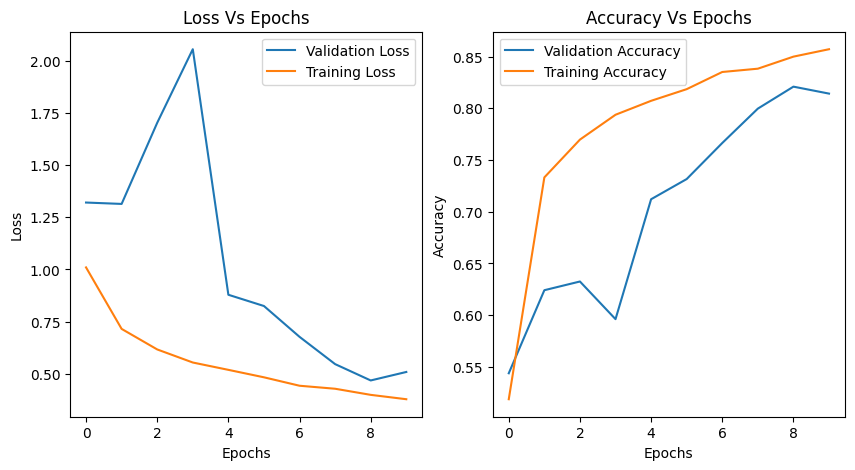

In [ ]:
# Plotting the Validation Loss N Validation Accuracy against the number of Epochs:
import pandas as pd
data = pd.DataFrame(model_history_tiles_small.history)
(a,b) = data.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), data['val_loss'], label = "Validation Loss")
plt.plot(range(a), data['loss'], label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), data['val_accuracy'], label = "Validation Accuracy")
plt.plot(range(a), data['accuracy'], label = "Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()

**Defining the model architecture - using pretrained resnet34**

In [ ]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.9 MB/s eta 0:00:00


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
###Model 
BACKBONE = 'resnet34'


In [ ]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=classes, activation='softmax')

#model.compile
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

85521592/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [ ]:
# Defining model callbacks:
from keras.callbacks import ModelCheckpoint
filepath = "patch_resnet34_small.h5"
callbacks_list = [ModelCheckpoint(filepath, save_best_only=True)]

In [ ]:
history=model.fit(X_train_processed, 
          train_masks,
          batch_size=3, 
          epochs=20,
          verbose=1,
          validation_data=(X_test_processed, val_masks),
          callbacks = callbacks_list)

Epoch 1/20
527/527 [==============================] - 59s 81ms/step - loss: 0.4799 - accuracy: 0.8236 - val_loss: 1.3950 - val_accuracy: 0.5858
Epoch 2/20
527/527 [==============================] - 40s 75ms/step - loss: 0.2709 - accuracy: 0.9043 - val_loss: 0.2435 - val_accuracy: 0.9069
Epoch 3/20
527/527 [==============================] - 40s 77ms/step - loss: 0.2228 - accuracy: 0.9202 - val_loss: 0.2424 - val_accuracy: 0.9100
Epoch 4/20
527/527 [==============================] - 41s 77ms/step - loss: 0.1929 - accuracy: 0.9283 - val_loss: 0.2420 - val_accuracy: 0.9174
Epoch 5/20
527/527 [==============================] - 40s 75ms/step - loss: 0.1656 - accuracy: 0.9382 - val_loss: 0.2497 - val_accuracy: 0.9161
Epoch 6/20
527/527 [==============================] - 41s 79ms/step - loss: 0.1706 - accuracy: 0.9350 - val_loss: 0.2319 - val_accuracy: 0.9139
Epoch 7/20
527/527 [==============================] - 42s 79ms/step - loss: 0.1570 - accuracy: 0.9402 - val_loss: 0.1994 - val_accuracy:

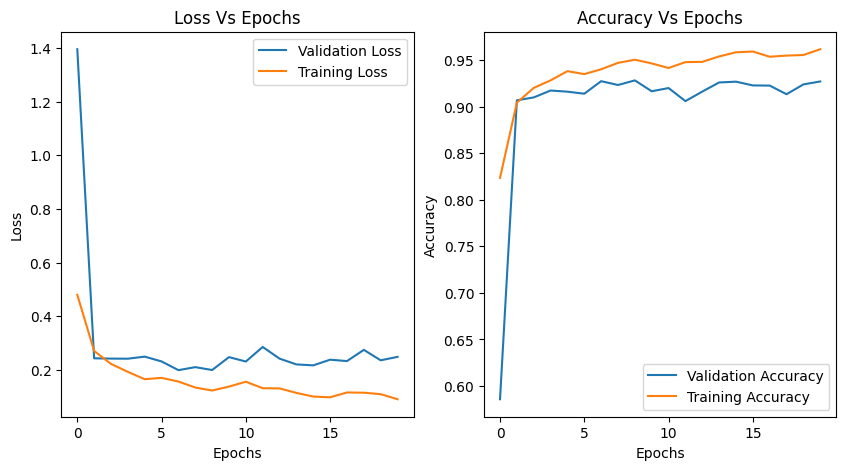

In [ ]:
# Plotting the Validation Loss N Validation Accuracy against the number of Epochs:
import pandas as pd
data = pd.DataFrame(history.history)
(a,b) = data.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), data['val_loss'], label = "Validation Loss")
plt.plot(range(a), data['loss'], label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), data['val_accuracy'], label = "Validation Accuracy")
plt.plot(range(a), data['accuracy'], label = "Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()

*Performing a prediction of the trained model on the validation(test) images:*

In [ ]:
from keras.models import load_model

model_path = '/content/patch_resnet34_small.h5'
model = load_model(model_path)
pred_masks = model.predict(val_images)
pred_masks = np.argmax(pred_masks, axis = 3)

3/3 [==============================] - 8s 1s/step


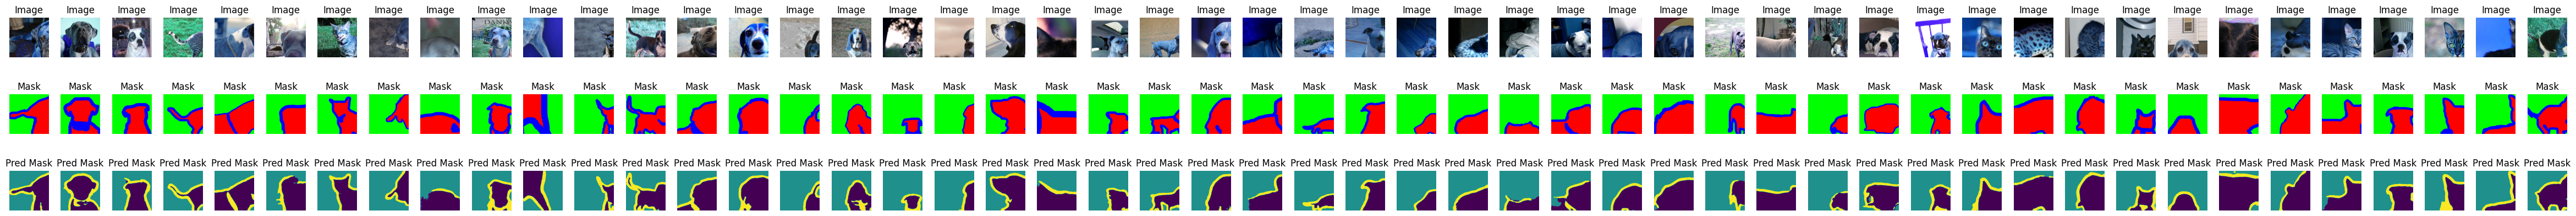

In [ ]:
# Create a 3-row, 25-column subplot grid with a fixed size
fig, axes = plt.subplots(nrows=3, ncols=50, figsize=(60, 5))

# Iterate over the first 25 images and masks
for i in range(50):
    # Plot the image on the top row of the subplot
    axes[0, i].imshow(val_images[i])
    axes[0, i].set_title('Image')
    axes[0, i].axis('off')

    # Plot the mask on the middle row of the subplot
    axes[1, i].imshow(val_masks[i])
    axes[1, i].set_title('Mask')
    axes[1, i].axis('off')

    # Plot the predicted mask on the bottom row of the subplot
    axes[2, i].imshow(pred_masks[i])
    axes[2, i].set_title('Pred Mask')
    axes[2, i].axis('off')

# Adjust the size and spacing of the subplots
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Show the plot
plt.show()

